# AI4IA Hackathon Phase 1: présentation du DataSet et exemple.s de prédiction

# Description:

Ce Notebook est mis à disposition des candidats du Challenge AI4IA-1ere Edition et est exclusivement dédié à cet évènement.

Le but de cet exemple classique est d'aider à la compréhension de ce qui est attendu des candidats, d'introduire les outils mis à disposition ainsi que les jeux de données et leur format. 

Les éléments fournis sont les suivants:
- jeu de données d'exemple (./data/DataSet_ex) sous la forme de plusieurs fichiers .csv, chacun correspondant à un signal d'excitation ;
- fichiers de définition des modèles et de leurs interfaces (cf. model_api.py et les exemples my_model1.py / my_model2.py). Note: le fichier de définition des modèles est la principale soumission des candidats: c'est à ce niveau qu'il est demandé d'implémenter l'architecture du modèle, ainsi que les stratégies d'inférence et d'entrainement;
- script générique pour le lancement d'un entraînement sur une instance AWS via sagemaker ou en local (sagemajer_api.py);
- scripts génériques pour l'évaluation des performances du modèle sur une instance AWS via sagemaker ou en local telles que définies pas les évaluateurs (les mêmes critères d'évaluation/métriques seront appliquées durant la phase d'évalutation, en considérant un jeu de données identique pour chaque candidat ainsi qu'une machine/instance AWS identique);
- une classe de test unitaire (cf. test_submission.py) permettant à tout instant de tester si la solution développée (la définition du modèle notamment) est conforme à ce qui est attendu et à ce qui sera mis en oeuvre lors de la phase d'évaluation. 

Note: il est donc indispensable que le modèle soumis par l'équipe candidate valide tous les tests unitaires et présente les caractéristiques nécessaires à l'évaluation de ses performances sur des instances AWS avec un fichier de test csv arbitraire (via calc_metrics_on_sagemaker.py). Il est donc vivement recommandé de s'assurer que le modèle développé présente bien ces caractéristiques.

Author: François Caire \
Maintainer: François Caire \
Email: francois.caire at skf.com 

# Sommaire :
1. [Chargement des Modules](#1-bullet)
2. [Chargement et exploration du DataSet](#2-bullet)
3. [Exemple Rudimentaire d'apprentissage](#3-bullet)
4. [Entraînement sur AWS SageMaker](#4-bullet)
5. [Evaluation de la solution en local et AWS SageMaker](#5-bullet)

# 1. Chargement des Modules <a class="anchor" id="1-bullet"></a>

Ici on importe les modules classiques

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import signal as sg
from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator

import time
from tqdm import notebook
import importlib

import torch
from torch.utils.data import TensorDataset, DataLoader

import tarfile

%matplotlib inline

In [2]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
                            # tables and data manipulations
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook


On ajoute des paramètres d'affichage et de tracé...

In [3]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 2.0

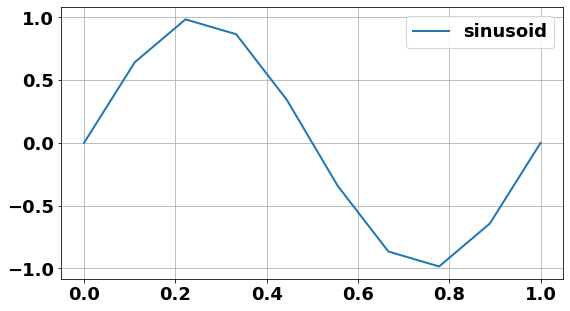

In [4]:
t=np.linspace(0,1,10)
y=np.sin(t*10*2*np.pi)

plt.figure(figsize=(9,5))
plt.plot(t,y,label='sinusoid')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [5]:
def nderiv(y,x):
    "Différence finie, dérivée de la fonction f"
    n = len(y)
    d = np.zeros(n,'d') # virgule flottante à double précision (double)
    # différences de part et d'autre
    # centrées sur les points intérieurs
    for i in range(1,n-1):
        d[i] = (y[i+1]-y[i-1])/(x[i+1]-x[i-1])
    # différences sur un seul côté pour les extrémités
    d[0] = (y[1]-y[0])/(x[1]-x[0])
    d[n-1] = (y[n-1]-y[n-2])/(x[n-1]-x[n-2])
    return d

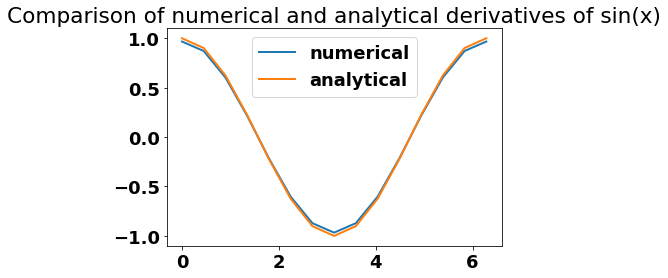

In [6]:
x = np.linspace(0,2*np.pi,15)
dsin = nderiv(np.sin(x),x)
plt.plot(x,dsin,label='numerical')
plt.plot(x,np.cos(x),label='analytical')
plt.title("Comparison of numerical and analytical derivatives of sin(x)")
plt.legend()

# 2. Chargement et Exploration/Tracé du DataSet d'exemple <a class="anchor" id="2-bullet"></a>

In [7]:
rep_data = "./data/DataSet_phase1/"
names = ["input"+str(k) for k in range(0,7)]

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)

In [8]:
d['input0'].head()

,Time,Output1,Input,Output2,Output3,Output4,Output5
0,0.000,-2.464122e-07,0.0,0.5,0.5,1.011923,1.00983
1,0.001,-2.464121e-07,0.0,0.5,0.5,1.011923,1.00983
2,0.002,-2.464121e-07,0.0,0.5,0.5,1.011923,1.00983
3,0.003,-2.464121e-07,0.0,0.5,0.5,1.011923,1.00983
4,0.004,-2.464121e-07,0.0,0.5,0.5,1.011923,1.00983


In [9]:
"""
d['input0']['deriv_input'] = nderiv(d['input0']['Input'], d['input0']['Time'])
d['input0'].plot(x='Time',y=['Input'],grid='on')
d['input0'].plot(x='Time',y=['deriv_input'],grid='on')
"""

"\nd['input0']['deriv_input'] = nderiv(d['input0']['Input'], d['input0']['Time'])\nd['input0'].plot(x='Time',y=['Input'],grid='on')\nd['input0'].plot(x='Time',y=['deriv_input'],grid='on')\n"

In [10]:
d['input1'].head()

,Time,Output1,Input,Output2,Output3,Output4,Output5
0,0.000,-2.464122e-07,0.0,0.5,0.5,1.011923,1.00983
1,0.001,-2.464121e-07,0.0,0.5,0.5,1.011923,1.00983
2,0.002,-2.464121e-07,0.0,0.5,0.5,1.011923,1.00983
3,0.003,-2.464121e-07,0.0,0.5,0.5,1.011923,1.00983
4,0.004,-2.464121e-07,0.0,0.5,0.5,1.011923,1.00983


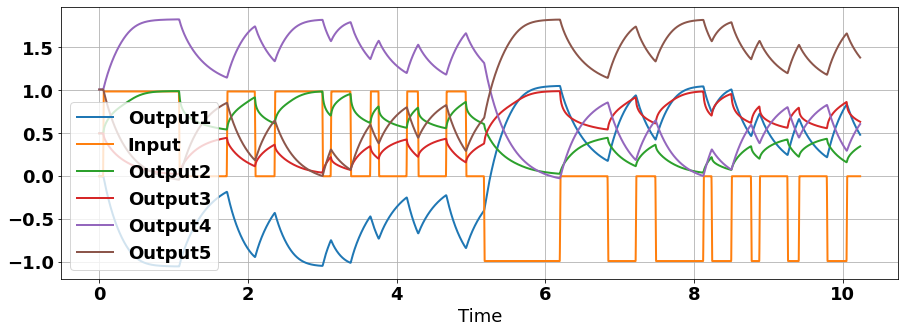

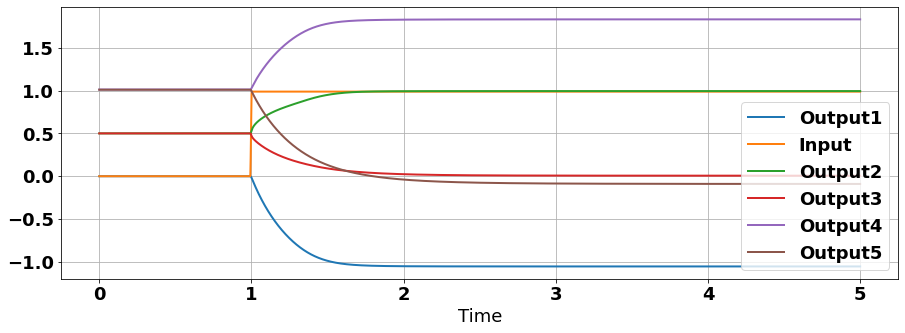

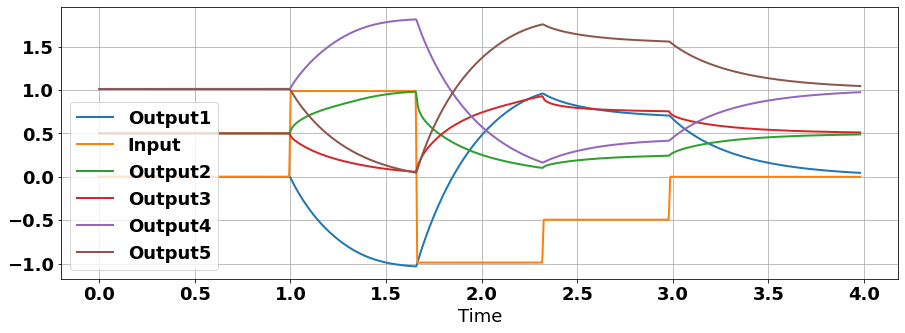

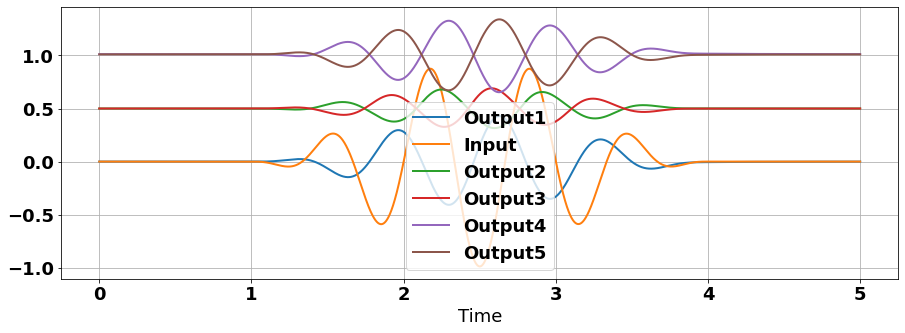

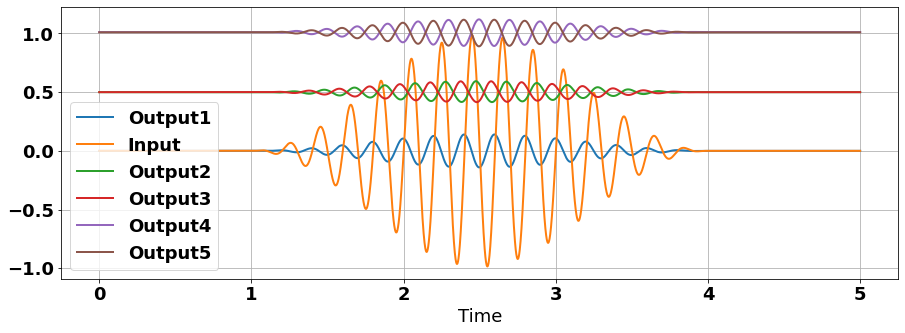

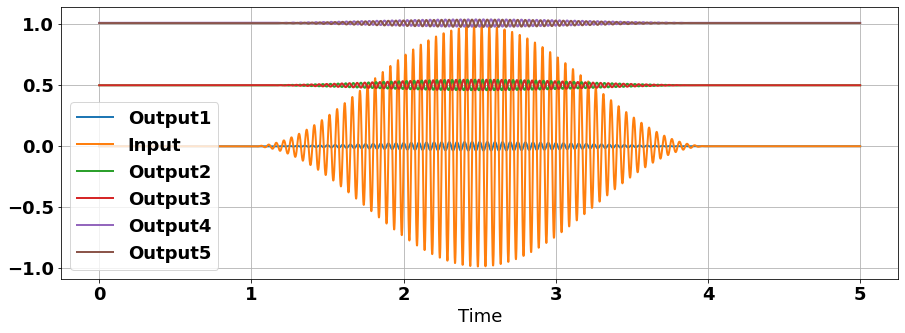

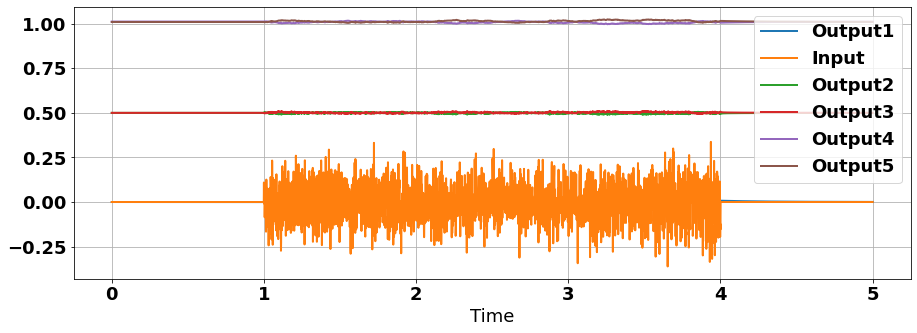

In [11]:
N_input   = 1
#N_outputs = 5
N_outputs = 1
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,5))
    #for k in range(N_outputs):
    #d[name].plot(ax=ax[k],x='Time',grid='on')
    d[name].plot(ax=ax,x='Time',grid='on')
        


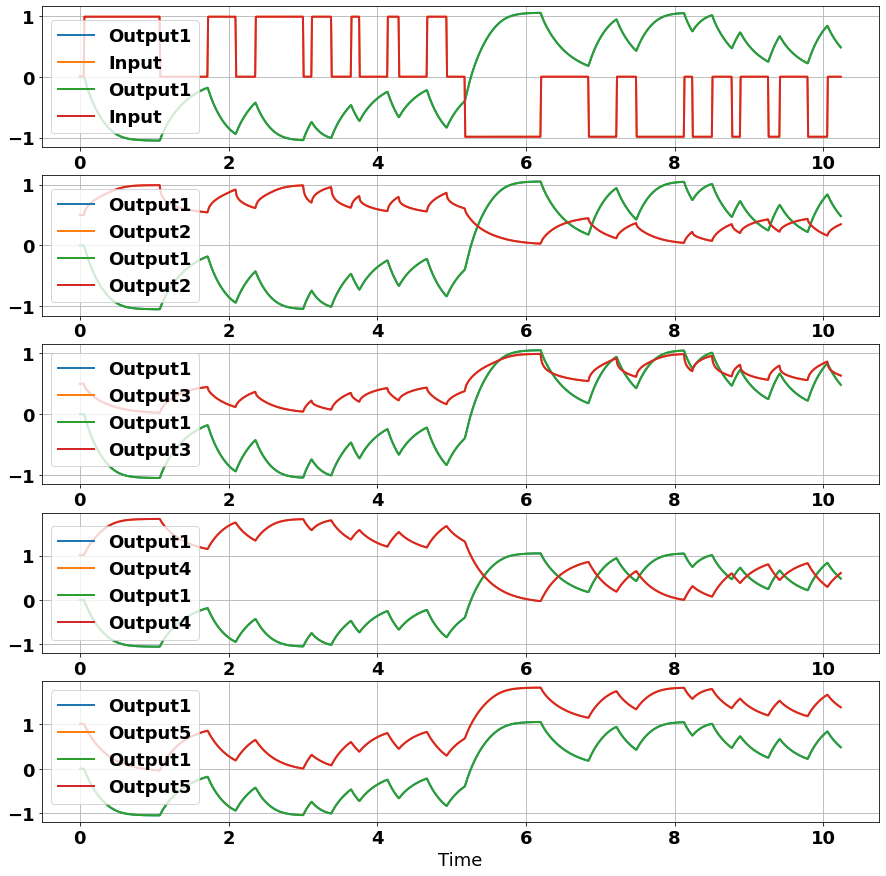

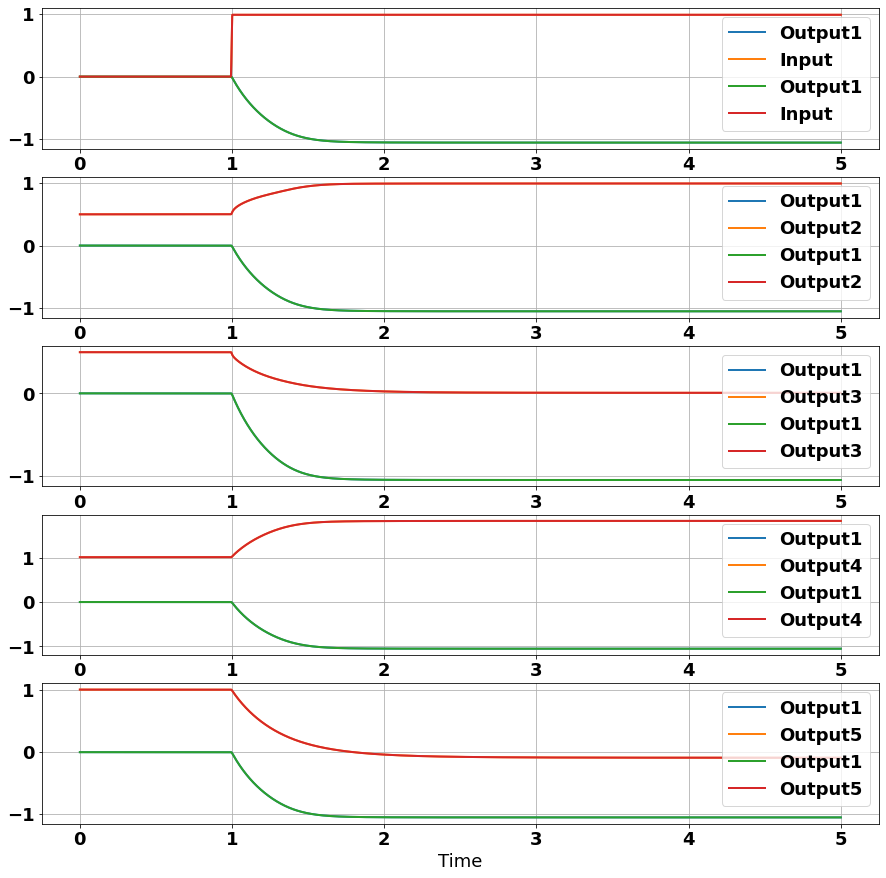

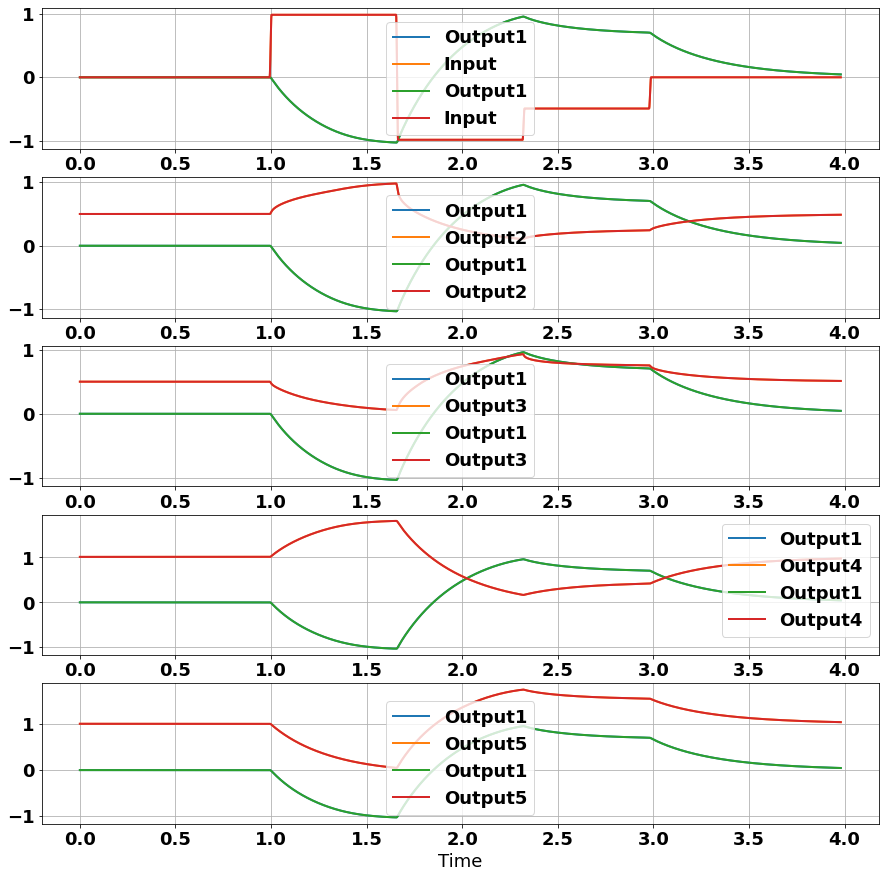

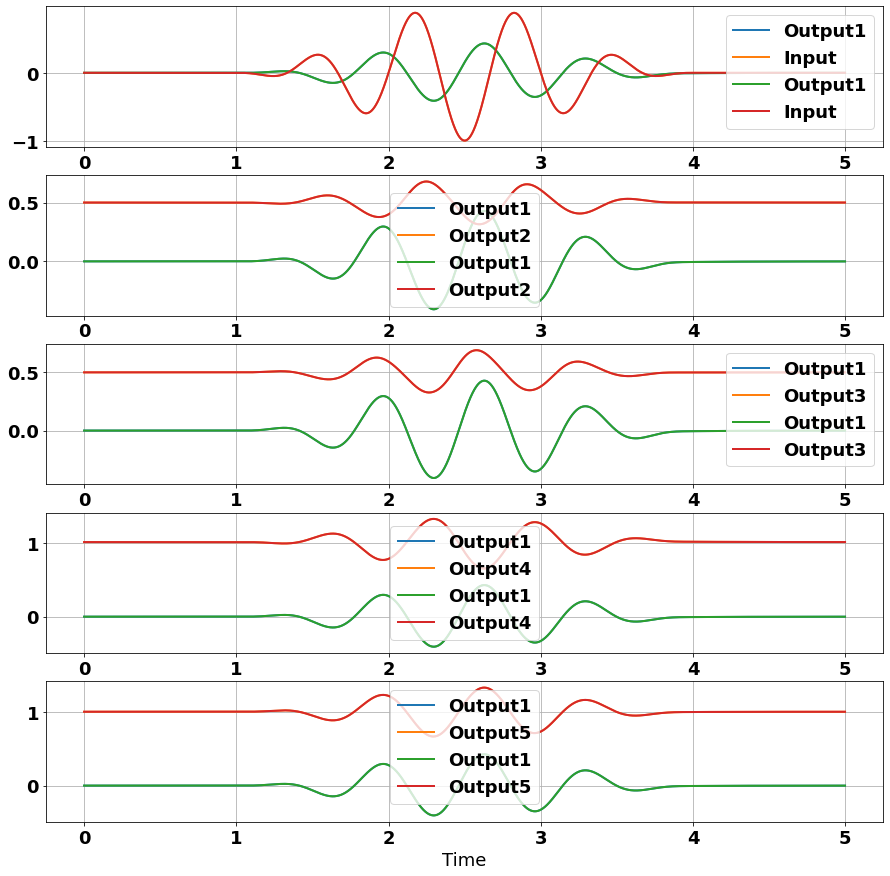

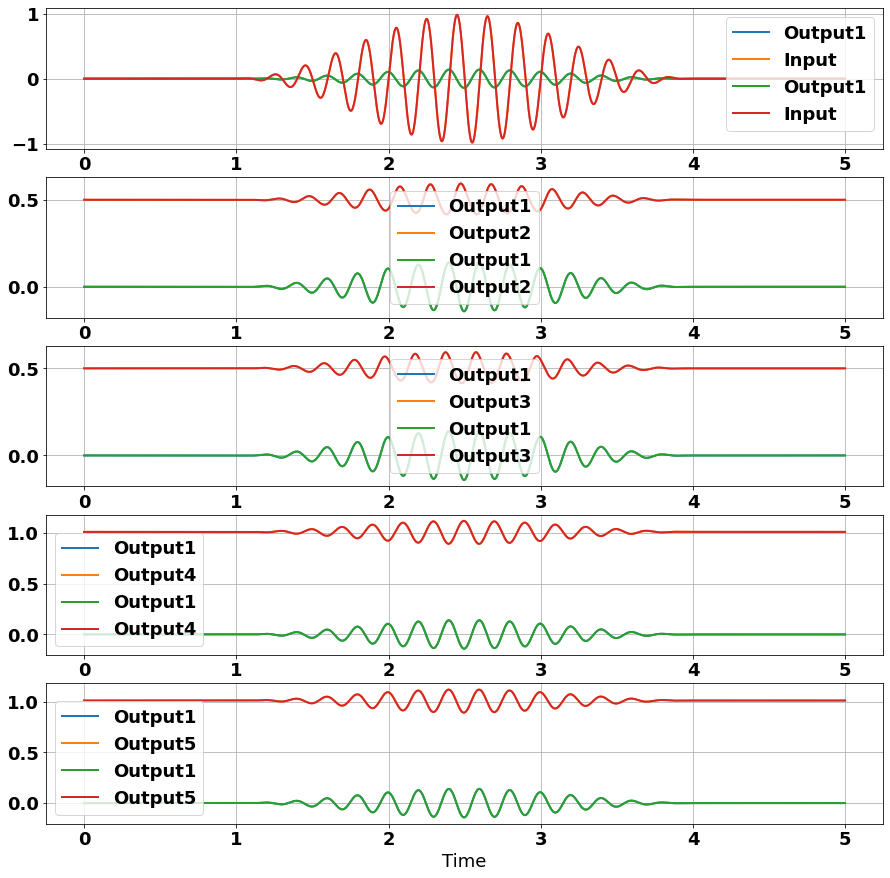

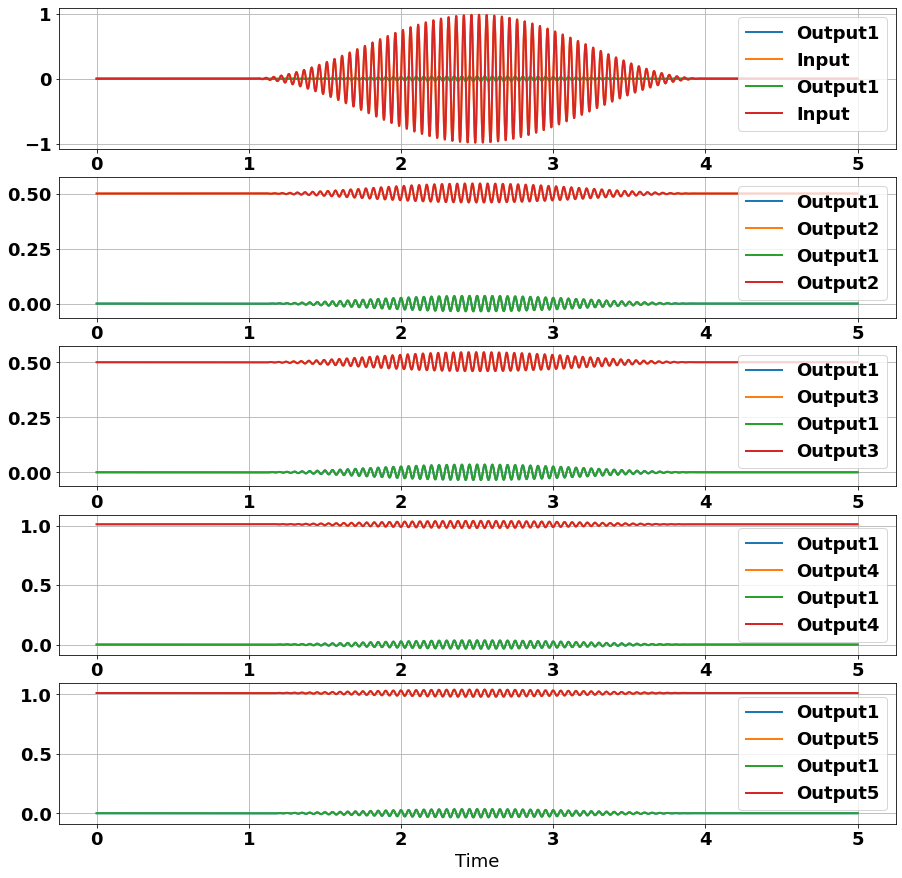

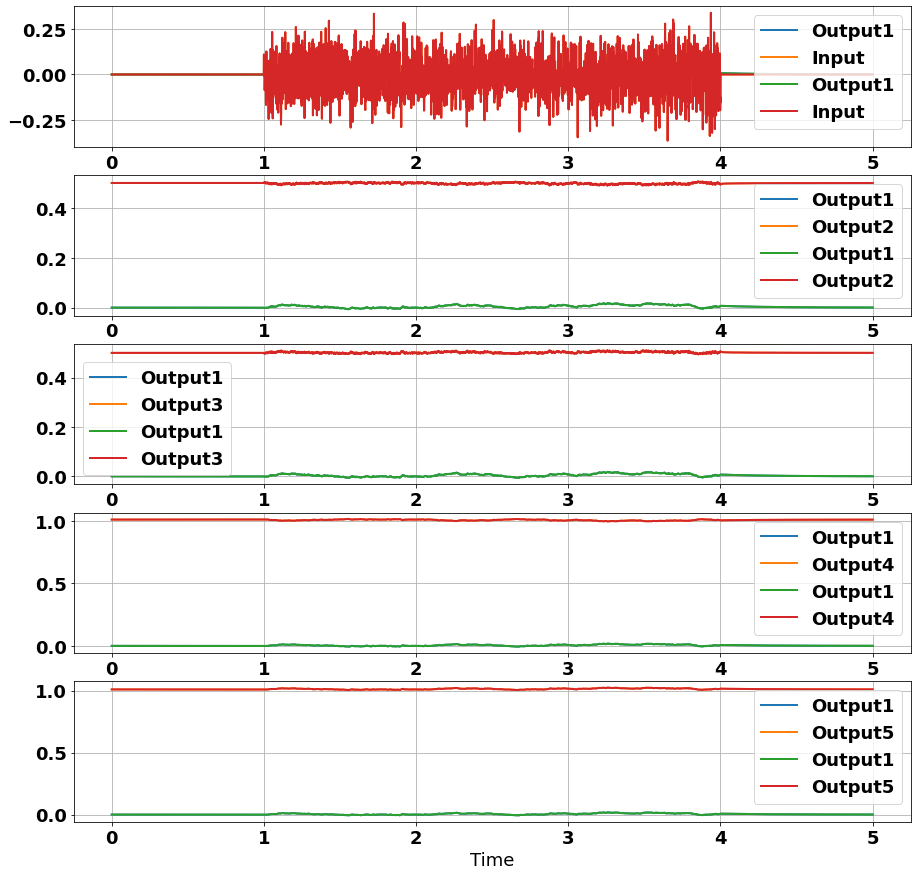

In [12]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')
        


In [13]:
from sources.utilities.utility_functions import *

t,x,y = load_data_csv("data/DataSet_ex/input1.csv")

# 3. Exemple rudimentaire d'apprentissage <a class="anchor" id="3-bullet"></a>

0. Chargement des modules d'intérêt

In [14]:
import sys
from importlib import reload,import_module
import os

import sagemaker
import boto3

1. On charge ici le modele créé specifiquement

In [15]:
model_definition = "my_model2"

MyModel = import_module('sources.utilities.' + model_definition).MyModel

On peut vérifier grâce aux tests unitaire que le modele est valide pour soumission (NB: il doit calculer cinq sorties pour les cinq grandeurs d'intérêt)

In [16]:
#!python3 sources/utilities/test_submission.py my_model1

#!python3 sources/utilities/test_submission.py my_model2
!python test_submission.py my_model1
!python test_submission.py my_model2

it. 0 / 25 - loss = 0.00131755
it. 1 / 25 - loss = 0.00048194
it. 2 / 25 - loss = 0.00014461
it. 3 / 25 - loss = 0.00017180
it. 4 / 25 - loss = 0.00033120
it. 5 / 25 - loss = 0.00039578
it. 6 / 25 - loss = 0.00033387
it. 7 / 25 - loss = 0.00022524
it. 8 / 25 - loss = 0.00012808
it. 9 / 25 - loss = 0.00007021
it. 10 / 25 - loss = 0.00005197
it. 11 / 25 - loss = 0.00006071
it. 12 / 25 - loss = 0.00008166
it. 13 / 25 - loss = 0.00010200
it. 14 / 25 - loss = 0.00011214
it. 15 / 25 - loss = 0.00010769
it. 16 / 25 - loss = 0.00009066
it. 17 / 25 - loss = 0.00006712
it. 18 / 25 - loss = 0.00004533
it. 19 / 25 - loss = 0.00002888
it. 20 / 25 - loss = 0.00001959
it. 21 / 25 - loss = 0.00001683
it. 22 / 25 - loss = 0.00001888
it. 23 / 25 - loss = 0.00002382
it. 24 / 25 - loss = 0.00002947
Model Description : 
{'affiliation': 'SKF Group',
 'description': 'This is a simple GRU model that supports 1 input and 1 to 5 '
                'outputs',
 'email': 'francois.caire@skf.com',
 'model_name': 'GR

In [17]:
!pygmentize "./sources/utilities/my_model2.py"

import os
import json
from typing import List

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# IMPORT THE MODEL API FROM WHICH YOUR MODEL MUST INHERITATE : 
try:
    from utilities.model_api import ModelApi
except:
    from sources.utilities.model_api import ModelApi
    
##################################################
## In this script, candidates are asked to implement two things:
#    1- the model, along with its training, prediction/inference methods;
#    2- the interface of this model with SKF evaluation and remote (AWS sagemaker) computation tools.
#
# See example notebook for an example of how to use this script
##################################################
## Author: François Caire
## Maintainer: François Caire
## Email: francois.caire at skf.com
##################################################

"""
BELOW IS THE IMPLEMENTATION OF YOUR MODEL

This example (GRUModel) implements a GRU class model inherited 

2. On selectionne le/les signaux utiles pour l'apprentissage et ceux pour la validation:

In [18]:
rep_data   = "data/DataSet_ex/"
file_train = "input4.csv"

t_train,x_train,y_train = load_data_csv(rep_data+file_train)

In [19]:
retrain = True

it. 0 / 150 - loss = 0.05513800
it. 6 / 150 - loss = 0.01218519
it. 12 / 150 - loss = 0.00493032
it. 18 / 150 - loss = 0.00248308
it. 24 / 150 - loss = 0.00169174
it. 30 / 150 - loss = 0.00139974
it. 36 / 150 - loss = 0.00127409
it. 42 / 150 - loss = 0.00120875
it. 48 / 150 - loss = 0.00117218
it. 54 / 150 - loss = 0.00115133
it. 60 / 150 - loss = 0.00113900
it. 66 / 150 - loss = 0.00113176
it. 72 / 150 - loss = 0.00112672
it. 78 / 150 - loss = 0.00112182
it. 84 / 150 - loss = 0.00111691
it. 90 / 150 - loss = 0.00111203
it. 96 / 150 - loss = 0.00110717
it. 102 / 150 - loss = 0.00110237
it. 108 / 150 - loss = 0.00109760
it. 114 / 150 - loss = 0.00109285
it. 120 / 150 - loss = 0.00108812
it. 126 / 150 - loss = 0.00108342
it. 132 / 150 - loss = 0.00107874
it. 138 / 150 - loss = 0.00107412
it. 144 / 150 - loss = 0.00106949


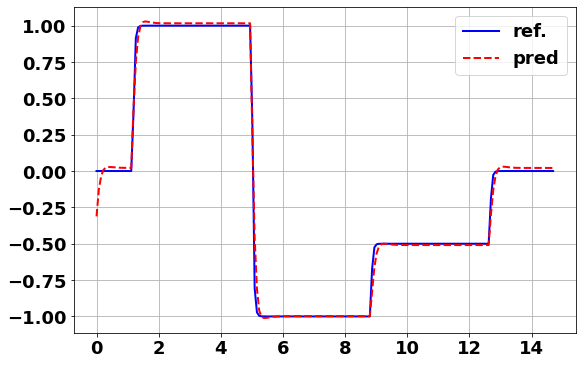

In [20]:
if retrain:
    Ndecim=5
    outputs_indexes = [0]
    model = MyModel.create_model(torch.cuda.is_available(), epochs=150, lr=0.05, output_size = len(outputs_indexes))

    model.fit(xs=x_train[::Ndecim], ys=[y_train[k][::Ndecim] for k in outputs_indexes])
    
    retrain = False

y_pred_train = model.predict_timeseries(x_train[::Ndecim])
for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_train[::Ndecim],y_train[outputs_indexes[k]][::Ndecim],'b',t_train[::Ndecim],y_pred_train[k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

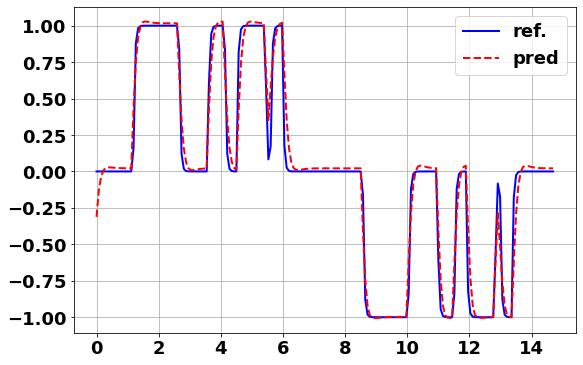

In [21]:
file_test  = "input1.csv"
t_test,x_test,y_test = load_data_csv(rep_data+file_test)

y_pred = model.predict_timeseries(x_test[::Ndecim])

for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_test[::Ndecim],y_test[outputs_indexes[k]][::Ndecim],'b',t_test[::Ndecim],y_pred[k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

# 4. Lancement sur AWS SageMaker <a class="anchor" id="4-bullet"></a>

0. Test local

Permet de vérifier que tout est ok avant de monter l'image sur une instance amazon (ce qui peut être long)

In [22]:
rep = "data/DataSet_ex/"
file_train = "input4.csv"
data = rep + file_train

use_gpu = True
epochs = 40
model_dir = "./models"
model_name = "model0"
lr = 0.05
Ndecim = 5
outputs_indexes = [0]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"

%run sources/sagemaker_api.py --use_gpu $use_gpu --lr $lr --epochs $epochs \
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --Ndecim $Ndecim --hyper_fileName $hyper_fileName\
                              --model_def_file $model_definition 


Failed to load default container env keys. Using local default keys.
it. 0 / 40 - loss = 0.06732761
it. 1 / 40 - loss = 0.05661160
it. 2 / 40 - loss = 0.18181694
it. 3 / 40 - loss = 0.31924683
it. 4 / 40 - loss = 0.13848144
it. 5 / 40 - loss = 0.04903018
it. 6 / 40 - loss = 0.00746635
it. 7 / 40 - loss = 0.03442426
it. 8 / 40 - loss = 0.03192941
it. 9 / 40 - loss = 0.02065209
it. 10 / 40 - loss = 0.00533082
it. 11 / 40 - loss = 0.00688760
it. 12 / 40 - loss = 0.01538434
it. 13 / 40 - loss = 0.00695236
it. 14 / 40 - loss = 0.00476324
it. 15 / 40 - loss = 0.00406392
it. 16 / 40 - loss = 0.00322480
it. 17 / 40 - loss = 0.00330004
it. 18 / 40 - loss = 0.00310195
it. 19 / 40 - loss = 0.00297038
it. 20 / 40 - loss = 0.00285450
it. 21 / 40 - loss = 0.00263631
it. 22 / 40 - loss = 0.00242984
it. 23 / 40 - loss = 0.00231343
it. 24 / 40 - loss = 0.00224905
it. 25 / 40 - loss = 0.00220164
it. 26 / 40 - loss = 0.00215286
it. 27 / 40 - loss = 0.00210676
it. 28 / 40 - loss = 0.00206782
it. 29 / 40 -

<Figure size 432x288 with 0 Axes>

In [23]:
t_train,x_train,y_train = load_data_csv(rep+file_train,Ndecim=Ndecim)
file_test  = "input3.csv"

In [24]:
model = MyModel.load(model_dir)

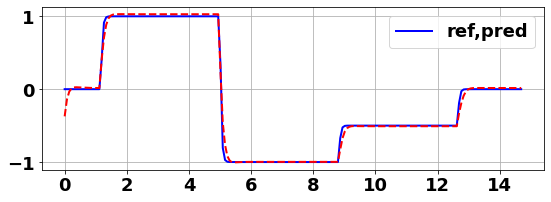

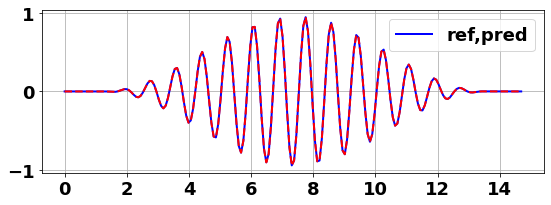

In [25]:
y_pred = model.predict_timeseries(x_train)

No = len(outputs_indexes)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_train,y_train[outputs_indexes[k]],'b',t_train,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_train,y_train[outputs_indexes[0]],'b',t_train,y_pred[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])
    
t_test,x_test,y_test = load_data_csv(rep+file_test,Ndecim=Ndecim)
y_pred = model.predict_timeseries(x_test)

fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_test,y_test[outputs_indexes[k]],'b',t_test,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_test,y_test[outputs_indexes[0]],'b',t_test,y_test[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    
plt.show()


1. Depôt des données sur S3

In [31]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix_in  = 'DEMO-AI4IA/input'
prefix_out = 'DEMO-AI4IA/model'
role = "arn:aws:iam::<...>:role/service-role/AmazonSageMaker-ExecutionRole-<...>"

ClientError: An error occurred (NotSignedUp) when calling the ListBuckets operation: Your account is not signed up for the S3 service. You must sign up before you can use S3.

In [ ]:
rep_data = './data/DataSet_ex/'

input_channel = sagemaker_session.upload_data(path=rep_data, bucket=bucket, key_prefix=prefix_in)
print('input file (in this case, just an S3 path): {}'.format(input_channel))


2. Creation des instances et paramétrage de l'estimateur:

In [ ]:
output_path = f's3://'+bucket+'/'+prefix_out

outputs_indexes = [0,1,2]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])

In [ ]:
model_name = 'model_GRU'
max_run = 60*60*6 # Max time in seconds

sagemaker_estimator,framework_version = model.get_sagemaker_estimator_class()
estimator = sagemaker_estimator(entry_point = 'sagemaker_api.py',
                                source_dir  = 'sources',
                                role = role,
                                py_version = 'py3',
                                max_run=max_run,
                                framework_version = framework_version,
                                instance_count = 1,
                                instance_type='ml.p3.2xlarge', #'ml.m4.xlarge',#'ml.p2.xlarge',#'ml.p3.2xlarge',#
                                output_path=f's3://'+bucket+'/'+prefix_out,
                                hyperparameters={
                                                    'use_gpu':True,
                                                    'epochs':350000,
                                                    'lr':.05,
                                                    'outputs_indexes': outputs_ind,
                                                    'Ndecim':5,
                                                    'train_fileName':file_train,
                                                    'model_def_file':'my_model2'
                                }
                               )

In [ ]:
estimator.fit({'training': input_channel})

In [ ]:
training_job_name = estimator.latest_training_job.name
desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
trained_model_location = desc['ModelArtifacts']['S3ModelArtifacts']
display('Model is here: {}'.format(trained_model_location))

s3 = boto3.resource('s3')    
s3.Bucket(bucket).download_file(os.path.join(prefix_out,desc['TrainingJobName'],'output/model.tar.gz'),'./models/model.tar.gz')

In [ ]:
model_dir = './models/model0'

with tarfile.open('./models/model.tar.gz','r:gz') as archived:
    archived.extractall(model_dir)

In [ ]:
model = MyModel.load(model_dir)

In [ ]:
outputs_indexes

In [ ]:
y_pred = model.predict_timeseries(x_train)

No = len(outputs_indexes)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_train,y_train[outputs_indexes[k]],'b',t_train,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_train,y_train[outputs_indexes[0]],'b',t_train,y_pred[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])

t_test,x_test,y_test = load_data_csv(rep+file_test,Ndecim=Ndecim)
y_pred = model.predict_timeseries(x_test)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:

    for k in range(No):
        ax[k].plot(t_test,y_test[outputs_indexes[k]],'b',t_test,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_test,y_test[outputs_indexes[0]],'b',t_test,y_test[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    
plt.show()


In [ ]:
rep = "data/DataSet_ex/"
file_train = "input1.csv"
data = rep + file_train

use_gpu = True
epochs = 40
model_dir = "./models/model1"
model_name = "model0"
lr = 0.05
Ndecim = 5
outputs_indexes = [0,1,2,3,4]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"

%run sources/sagemaker_api.py --use_gpu $use_gpu --lr $lr --epochs $epochs \
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --Ndecim $Ndecim --hyper_fileName $hyper_fileName

# 5. Evaluation des solutions <a class="anchor" id="5-bullet"></a>

0. Recuperation des paramètres (modele et entraînement)

In [ ]:
with open("./models/model1/hyper.json","r") as f:
    dHyper = json.load(f)

with open("models/model1/model_kwargs.json","r") as f:
    dKwargs = json.load(f)

In [ ]:
dHyper,dKwargs

1. Local metric tests

In [ ]:
model1 = MyModel(**dKwargs)

In [ ]:
data_dir = "./data/DataSet_ex"
hyper_filename  = "hyper.json"
kwargs_filename = "model_kwargs.json"
test_filename   = 'input2.csv'
model_dir       = './models/model1'
model_def_file  = 'my_model2'

%run sources/calc_metrics.py --data_dir $data_dir \
                             --model_dir $model_dir \
                             --estimator_hyperParams_fileName $hyper_fileName \
                             --model_kwargs_fileName $kwargs_filename \
                             --test_fileName $test_filename \
                             --model_def_file $model_def_file


In [ ]:
with open('./metrics/s2m_GRU2_metrics','r') as f: print(f.read())

2. AWS Metrics tests

In [ ]:
metrics_dir = './metrics_sage'
model_def_file = "my_model1"
type_instance = 'ml.m5.xlarge' # Mention that the time limit is t on this specific type of instance

%run calc_metrics_on_sagemaker.py --data_dir $data_dir \
                                  --model_dir $model_dir \
                                  --role $role \
                                  --estimator_hyperParams_fileName $hyper_fileName \
                                  --model_kwargs_fileName $kwargs_filename \
                                  --test_fileName $test_filename \
                                  --out_dir $metrics_dir \
                                  --model_def_file $model_def_file

In [ ]:
with open(os.path.join(metrics_dir,'s2m' '_' + 'GRU1' + '_metrics'),'r') as f:  print(f.read())

In [ ]:
metrics_dir = './metrics_sage'
model_def_file = "my_model2"

%run calc_metrics_on_sagemaker.py --data_dir $data_dir \
                                  --model_dir $model_dir \
                                  --role $role \
                                  --estimator_hyperParams_fileName $hyper_fileName \
                                  --model_kwargs_fileName $kwargs_filename \
                                  --test_fileName $test_filename \
                                  --out_dir $metrics_dir \
                                  --model_def_file $model_def_file

In [ ]:
with open(os.path.join(metrics_dir,'s2m' '_' + 'GRU2' + '_metrics'),'r') as f:  print(f.read())

In [ ]:
!pipreqs ./ --force